### 19. Proces M/M/1 - zależność od tempa obsługi zdarzeń
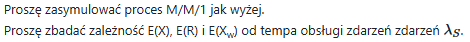

In [5]:
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

In [2]:
class QueueingSystem:
    def __init__(self, lambdaA, lambdaS, server_capacities=[-1], n_events=1_000_000): # -1 -> inf
        self.lambdaA = lambdaA # arrival rate
        self.lambdaS = lambdaS # service rate
        self.muA = 1 / lambdaA # mean inter-arrival time
        self.muS = 1 / lambdaS # mean service time

        self.n_servers = len(server_capacities)
        self.server_capacities = server_capacities
        self.n_events = n_events

        self.queues = [deque() for _ in range(self.n_servers)]
        self.server_busy_until = [0] * self.n_servers
        self.current_time = 0

        # \beta is the scale parameter, which is the inverse of the rate parameter \lambda = 1/\beta. 
        # The rate parameter is an alternative, widely used parameterization of the exponential distribution
        self.arrival_times = deque(np.cumsum(np.random.exponential(self.muA, self.n_events)))
        self.service_times = deque(np.random.exponential(self.muS, self.n_events))

        self.results = []

    def simulate(self):
        while self.arrival_times or any(len(queue) > 0 for queue in self.queues):
            self.handle_depatrure()

            while self.arrival_times and self.arrival_times[0] <= self.current_time: # 2x while self.arrival?
                self.current_time = self.arrival_times.popleft()
                service_time = self.service_times.popleft()
                self.handle_arrival(self.current_time, service_time)
            
            next_event_times = []
            for busy_until in self.server_busy_until:
                if busy_until > self.current_time:
                    next_event_times.append(busy_until)
            if self.arrival_times:
                next_event_times.append(self.arrival_times[0])

            

            if next_event_times:
                self.current_time = min(next_event_times)
            else:
                break

    def handle_arrival(self, arrival_time, service_time):
        # all servers are busy, add customer to the shortest queue
        queue_lengths = [len(q) for q in self.queues]
        min_queue_length = min(queue_lengths)
        min_queue_index = queue_lengths.index(min_queue_length)

        capacity = self.server_capacities[min_queue_index]
        if capacity == -1 or len(self.queues[min_queue_index]) < capacity:
            self.queues[min_queue_index].append((arrival_time, service_time))
        else:
            # reject the customer, queue is full
            pass

    def handle_depatrure(self):
        for i in range(self.n_servers):
            if self.server_busy_until[i] <= self.current_time:
                if self.queues[i]:
                    arrival_time, service_time = self.queues[i].popleft()
                    start_time = max(arrival_time, self.current_time)
                    self.server_busy_until[i] = start_time + service_time
                    self.results.append({
                        'Arrival time': arrival_time,
                        'Service start time': start_time,
                        'Service time': service_time,
                        'Departure time': start_time + service_time,
                        'Server': i
                    })

    def calculate_average_time_in_system(self):
        total_time_in_system = 0
        for result in self.results:
            time_in_system = result['Departure time'] - result['Arrival time']
            total_time_in_system += time_in_system
        average_time_in_system = total_time_in_system / len(self.results)
        return average_time_in_system

    def calculate_arrival_rate(self):
        total_arrivals = len(self.results)
        total_time = self.current_time
        arrival_rate = total_arrivals / total_time
        return arrival_rate

    def calculate_average_number_in_system(self):
        event_times = []
        for result in self.results:
            event_times.append((result['Arrival time'], 'arrival'))
            event_times.append((result['Departure time'], 'departure'))
        event_times.sort()

        num_in_system = 0
        last_event_time = 0
        area_under_curve = 0

        for time, event_type in event_times:
            time_interval = time - last_event_time
            area_under_curve += num_in_system * time_interval
            last_event_time = time

            if event_type == 'arrival':
                num_in_system += 1
            else:
                num_in_system -= 1

        total_time = self.current_time
        average_number_in_system = area_under_curve / total_time
        return average_number_in_system

In [3]:
lambdaA = [1/15, 1/20, 1/25] # tempo nadchodzenia zadań
lambdaS = [1/15, 1/20, 1/25] # tempo obsługi zadań
for lA in lambdaA:
    for lS in lambdaS:
        mm1 = QueueingSystem(lA, lS)
        print("λA:", lA, "λS:", lS)
        mm1.simulate()
        # theoretical Little's law results:
        average_time_in_system = mm1.calculate_average_time_in_system()
        arrival_rate = mm1.calculate_arrival_rate()
        average_number_in_system = mm1.calculate_average_number_in_system()

        print("Tempo nadchodzenia zadań (λ):", arrival_rate)
        print("Średni czas spędzony w systemie (W):", average_time_in_system)
        print("Średnia liczba zadań w systemie (L):", average_number_in_system)
        print("λ * W:", arrival_rate * average_time_in_system)
        print()

λA: 0.06666666666666667 λS: 0.06666666666666667
Tempo nadchodzenia zadań (λ): 0.06650805801771634
Średni czas spędzony w systemie (W): 4477.534335395485
Średnia liczba zadań w systemie (L): 297.79211335480176
λ * W: 297.7921133547999

λA: 0.06666666666666667 λS: 0.05
Tempo nadchodzenia zadań (λ): 0.04999201259763915
Średni czas spędzony w systemie (W): 2511414.4800988277
Średnia liczba zadań w systemie (L): 125550.66432699267
λ * W: 125550.66432699397

λA: 0.06666666666666667 λS: 0.04
Tempo nadchodzenia zadań (λ): 0.04001615678871503
Średni czas spędzony w systemie (W): 4993322.627033217
Średnia liczba zadań w systemie (L): 199813.5811400074
λ * W: 199813.58113999962

λA: 0.05 λS: 0.06666666666666667
Tempo nadchodzenia zadań (λ): 0.050082039975438655
Średni czas spędzony w systemie (W): 69.65408196617706
Średnia liczba zadań w systemie (L): 3.488418517482343
λ * W: 3.48841851748256

λA: 0.05 λS: 0.05
Tempo nadchodzenia zadań (λ): 0.049952550617441055
Średni czas spędzony w systemie (W)

In [4]:
lambdaA_values = np.linspace(1/25, 1/15, 20)  
lambdaS = 1/20  # Fix service rate

E_R = np.ones_like(lambdaA_values) * (1/lambdaS)  # Expected service time
E_X = E_R/(1-lambdaA_values/lambdaS)  # Expected system time 
E_Xw = (lambdaA_values/lambdaS * E_R)/(1-lambdaA_values/lambdaS)  # Expected waiting time

plt.figure(figsize=(15, 5))

# Plot E(R)
plt.subplot(131)
plt.plot(lambdaA_values, E_R)
plt.title('E(R) vs λA')
plt.xlabel('λA')
plt.ylabel('E(R)')
plt.grid(True)

# Plot E(X) 
plt.subplot(132)
plt.plot(lambdaA_values, E_X)
plt.title('E(X) vs λA') 
plt.xlabel('λA')
plt.ylabel('E(X)')
plt.grid(True)

# Plot E(Xw)
plt.subplot(133)
plt.plot(lambdaA_values, E_Xw)
plt.title('E(Xw) vs λA')
plt.xlabel('λA')
plt.ylabel('E(Xw)')
plt.grid(True)

plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined